In [6]:
import numpy as np
import pylab as plt

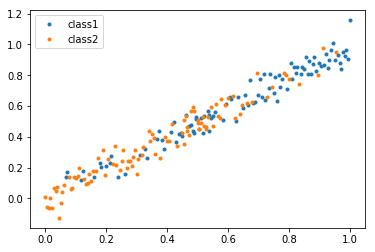

In [12]:
def f(x,m,c):
    return m*x + c

x1=np.linspace(0,0.55,100)
y1=f(x1+np.random.normal(0,0.06,100),1,0)

x2=np.linspace(0.45,1,100)
y2=f(x2+np.random.normal(0,0.06,100),1,0)

xx = np.concatenate((x1,x2))
yy = np.concatenate((y1,y2))

classx_x = []
classo_x = []


classx_y = []
classo_y = []

for i in range(len(xx)):
    if np.random.uniform(0,1) <= xx[i]:
        classx_x.append(xx[i])
        classx_y.append(yy[i])
    else:
        classo_x.append(xx[i])
        classo_y.append(yy[i])



plt.plot(classx_x,classx_y,'.',label='class0') # class 0
plt.plot(classo_x,classo_y,'.',label='class1') # class 1
plt.legend()
plt.show()
